In [ ]:
import numpy as np
import pandas as pd
import math
from google.colab import drive
import os
#drive.mount("/content/gdrive/")
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import tensorflow.keras
from sklearn.metrics import r2_score

In [ ]:
fn = "/content/gdrive/My Drive/DATASET_for_Python_new.xlsx"
Raw_raw = pd.read_excel(fn, sheet_name = 'Raw')
PE_raw = pd.read_excel(fn, sheet_name = 'PE')
SFE_raw = pd.read_excel(fn, sheet_name = 'SFE')
Etc_raw = pd.read_excel(fn, sheet_name = 'Etc')

In [ ]:
Raw_raw.usecols = ['Date', 'Month', 'T_Raw_MGD', 'Recycle_MGD', 'Temp_C','BODRaw_Conc._mg.l','NH3Raw_Conc._mg.l',
                   'TPRaw_Conc._mg.l','SPRaw_Conc._mg.l','TSSRaw_Conc._mg.l','VSSRaw_Conc._mg.l','Aver. FerricRaw_Conc._mg.l']
Raw = Raw_raw.loc[:,Raw_raw.usecols]

#PE Sheet
PE_raw.usecols = ['PE Flow_MGD','BODPE_Conc._mg.l','CODPE_Conc._mg.l','TSSPE_Conc._mg.l','VSSPE_Conc._mg.l','SPPE_Conc._mg.l',
                  'f.TPPE_Conc']
PE = PE_raw.loc[:,PE_raw.usecols]

#SFE Sheet
SFE_raw.usecols = ['BODSFE_Conc._mg.l','NH3SFE_Conc._mg.l','SPSFE_Conc._mg.l','TPSFE_Conc._mg.l',
                   'TSSSFE_Conc._mg.l','TSSFE_Conc._mg.l']
SFE = SFE_raw.loc[:,SFE_raw.usecols]

# Etc. Sheet
Etc_raw.usecols = ['RAS_FlowMGD','RAW_TSSmg.l','Pred_RASmg.l','MLSSmg.l','MVLSSmg.l','MVLSS.MLSS%',
                   'SVIml.mg','SRT_PredDays','SRT_MeasuredDays','Sludge_Blanket_Depth_ft',]
Etc = Etc_raw.loc[:,Etc_raw.usecols]

#Merging df
df = pd.concat([Raw,PE,SFE,Etc], axis=1)
df['Date'] = pd.to_datetime(df['Date']).dt.date #remove time from datetime
df = df.set_index('Date') # set index with Date
df.info()

df.columns = ["Month","Raw_Flow", "Recycle_Flow", "Temp", "Raw_BOD","Raw_NH3", "Raw_TP","Raw_SP","Raw_TSS","Raw_VSS","Ferric",
              "PE_Flow","PE_BOD","PE_COD","PE_TSS","PE_VSS","PE_SP","PE_fTP",
              "SFE_BOD","SFE_NH3","SFE_SP","SFE_TP","SFE_TSS","SFE_TS",
              "RAS_Flow","RAS_TSS","Pred_RAS_TSS","MLSS","MLVSS","MLVSS_MLSS","SVI","SRT","SRT_cal","SLBk"]

# Adding additional parameter written by Anar
#week day
df['week_day'] = np.arange(2,3167)%7
df['Mn'] = (df['week_day'].values == 1)+np.zeros(3165)
df['Ts'] = (df['week_day'].values == 2)+np.zeros(3165)
df['Wed'] = (df['week_day'].values == 3)+np.zeros(3165)
df['Th'] = (df['week_day'].values == 4)+np.zeros(3165)
df['Fr'] = (df['week_day'].values == 5)+np.zeros(3165)
df['Sat'] = (df['week_day'].values == 6)+np.zeros(3165)
df['Sun'] = (df['week_day'].values == 0)+np.zeros(3165)

#season
df['Winter'] = ((df['Month'] > 11)  | (df["Month"]<3)) + np.zeros(3165)
df['Summer'] = ((df['Month'] > 5)  & (df["Month"]<9)) + np.zeros(3165)
df['Fall'] = ((df['Month'] > 8)  & (df["Month"]<12)) + np.zeros(3165)
df['Spring'] = ((df['Month'] > 2)  & (df["Month"]<6)) + np.zeros(3165)

# Moving Average > choose ma1
df['t1_TP'] = df['SFE_TP'].rolling(window=1).mean()
df['t1_TSS'] = df['SFE_TSS'].rolling(window=1).mean()
df['t1_SP'] = df['SFE_SP'].rolling(window=1).mean()
# lag a row by group '1d'
df['t1_TP'] = df['t1_TP'].shift(1)
df['t1_TSS'] = df['t1_TSS'].shift(1)
df['t1_SP'] = df['t1_SP'].shift(1)

# Delete first row to remove NA in t1 values
df = df.dropna(subset=['t1_TP'])
df = df.fillna(df.mean(axis=0)) # Mean to NaN
#df=df.fillna(method="ffill", axis=0) #fill with previous value
#df.where(pd.notnull(df), df.mean(), axis='columns')
print(df.info())    

#Normalizing dataset
min_max_scaler = preprocessing.MinMaxScaler()
scaled_df_conc = min_max_scaler.fit_transform(df)
scaled_df_conc = pd.DataFrame(scaled_df_conc, index=df.index, columns=df.columns)

X = scaled_df_conc.loc[:,["Month", "Temp", "Raw_TP","Raw_SP","Ferric",
              "PE_Flow","PE_SP","PE_fTP","MLVSS","SRT","SLBk",
              't1_TP','t1_TSS', 't1_SP']]
unscaled_y = df.loc[:,'SFE_TP'] # removed Outliers

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, unscaled_y, test_size=0.25)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train.info())  

Lasso_model = linear_model.Lasso(alpha=0.001)
Lasso_model.fit(X_train, y_train)
print(round(Lasso_model.score(X_test, y_test),3), "Lasso Regression")

usefull_columns = []

for i in range(len(X_train.columns)):
  if abs(Lasso_model.coef_[i]) > 0.00001:
    usefull_columns.append(X_train.columns[i])
print(mean_squared_error(y_test, Lasso_model.predict(X_test)))

len(usefull_columns)

X = scaled_df_conc.loc[:,usefull_columns]
unscaled_y = df.loc[:,'SFE_TP'] # removed Outliers

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, unscaled_y, test_size=0.25)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X.info()) 

<class 'pandas.core.frame.DataFrame'>
Index: 3165 entries, 2013-01-01 to 2021-08-31
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Month                       3165 non-null   int64  
 1   T_Raw_MGD                   3165 non-null   float64
 2   Recycle_MGD                 3165 non-null   float64
 3   Temp_C                      3165 non-null   float64
 4   BODRaw_Conc._mg.l           3147 non-null   float64
 5   NH3Raw_Conc._mg.l           843 non-null    float64
 6   TPRaw_Conc._mg.l            3157 non-null   float64
 7   SPRaw_Conc._mg.l            3157 non-null   float64
 8   TSSRaw_Conc._mg.l           3159 non-null   float64
 9   VSSRaw_Conc._mg.l           3159 non-null   float64
 10  Aver. FerricRaw_Conc._mg.l  3104 non-null   float64
 11  PE Flow_MGD                 3165 non-null   float64
 12  BODPE_Conc._mg.l            3159 non-null   float64
 13  CODPE_Conc._mg.l       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [ ]:
# Vanilla model
modelNN1 = Sequential()
modelNN1.add(tensorflow.keras.Input(shape=len(usefull_columns)))
modelNN1.add(Dense(50, activation='elu', use_bias=True)) ##INPUT dimension adjusted from 21 to 22
modelNN1.add(Dense(50, activation='elu', use_bias=True))
modelNN1.add(Dense(20, activation='elu', use_bias=True))
modelNN1.add(Dense(1, activation='linear'))

In [ ]:
modelNN1.compile(optimizer=Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='mean_squared_error')

In [ ]:
modelNN1.fit(X_train, y_train, batch_size=100, epochs=200)

Epoch 1/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0732
Epoch 2/200
24/24 [==============================] - 0s 2ms/step - loss: 0.0232
Epoch 3/200
24/24 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 4/200
24/24 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 5/200
24/24 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 6/200
24/24 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 7/200
24/24 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 8/200
24/24 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 9/200
24/24 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 10/200
24/24 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 11/200
24/24 [==============================] - 0s 2ms/step - loss: 0.0191
Epoch 12/200
24/24 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 13/200
24/24 [=================

In [ ]:
y_pred_NN1 = modelNN1.predict(X_test)

In [ ]:
modelNN1.evaluate(X_test,y_test)

25/25 [==============================] - 0s 2ms/step - loss: 0.0151


0.015142267569899559

In [ ]:
r2_score(y_test, y_pred_NN1)

0.5802911383570954

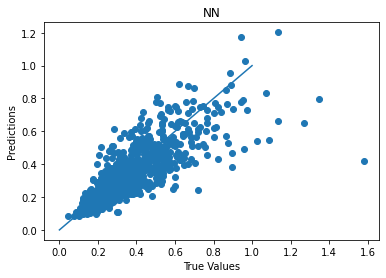

In [ ]:
plt.scatter(y_test, y_pred_NN1)
x_vals = [0, 1]
y_vals = [0, 1]
plt.plot(x_vals, y_vals)
plt.title('NN')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [ ]:
backward = 7
X_train_LSTM = []
for i in range(backward, X_train.shape[0]):
  X_train_LSTM.append(X[i-backward+1:i+1])

In [ ]:
X_train_LSTM = np.array(X_train_LSTM)

In [ ]:
X_test_LSTM = []
length = X_train.shape[0]
for i in range(backward, X_test.shape[0]):
  X_test_LSTM.append(X[i+length-backward+1:i+length+1])

In [ ]:
X_test_LSTM = np.array(X_test_LSTM)

In [ ]:
y_test_LSTM = unscaled_y[length+backward:]

In [ ]:
y_train_LSTM = unscaled_y[backward:length]

In [ ]:
modelLSTM = Sequential()
modelLSTM.add(LSTM(50, return_sequences=True))
modelLSTM.add(LSTM(20, return_sequences=False))
modelLSTM.add(Dense(10, activation="relu", use_bias=True))
modelLSTM.add(Dense(1, activation='linear', use_bias=True))

In [ ]:
modelLSTM.compile(optimizer=Adam(learning_rate=0.003, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='mean_squared_error')

In [ ]:
modelLSTM.fit(X_train_LSTM, y_train_LSTM, batch_size=100, epochs=50)

Epoch 1/50
24/24 [==============================] - 5s 13ms/step - loss: 0.0428
Epoch 2/50
24/24 [==============================] - 0s 13ms/step - loss: 0.0275
Epoch 3/50
24/24 [==============================] - 0s 12ms/step - loss: 0.0261
Epoch 4/50
24/24 [==============================] - 0s 13ms/step - loss: 0.0266
Epoch 5/50
24/24 [==============================] - 0s 13ms/step - loss: 0.0242
Epoch 6/50
24/24 [==============================] - 0s 13ms/step - loss: 0.0238
Epoch 7/50
24/24 [==============================] - 0s 12ms/step - loss: 0.0225
Epoch 8/50
24/24 [==============================] - 0s 13ms/step - loss: 0.0218
Epoch 9/50
24/24 [==============================] - 0s 12ms/step - loss: 0.0209
Epoch 10/50
24/24 [==============================] - 0s 12ms/step - loss: 0.0202
Epoch 11/50
24/24 [==============================] - 0s 12ms/step - loss: 0.0197
Epoch 12/50
24/24 [==============================] - 0s 14ms/step - loss: 0.0189
Epoch 13/50
24/24 [==================

In [ ]:
y_pred_lstm = modelLSTM.predict(X_test_LSTM)

In [ ]:
modelLSTM.evaluate(X_test_LSTM, y_test_LSTM)

25/25 [==============================] - 1s 3ms/step - loss: 0.0170


0.017009690403938293

In [ ]:
r2_score(y_test_LSTM, y_pred_lstm)

0.6135861069131968

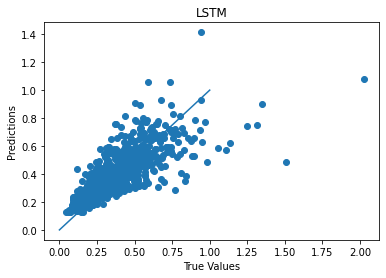

In [ ]:
plt.scatter(y_test_LSTM, y_pred_lstm)
x_vals = [0, 1]
y_vals = [0, 1]
plt.plot(x_vals, y_vals)
plt.title('LSTM')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
LRModel = LinearRegression()
m = LinearSVR(epsilon=0.01)
m_SVR = SVR(C=1.0, epsilon=0.001, kernel='rbf')
m_SVR.fit(X_train, y_train)
LRModel.fit(X_train, y_train)
y_pred_lr = LRModel.predict(X_test)
print(mean_squared_error(y_pred_lr,y_test), "Linear Regression")
m.fit(X_train,y_train)
y_pred_LinSVR = m.predict(X_test)
print(mean_squared_error(y_pred_LinSVR,y_test),"Linear SVR")
y_pred_SVR = m_SVR.predict(X_test)
print(mean_squared_error(y_pred_SVR,y_test),"SVR")

0.014661681118179837 Linear Regression
0.0144630717563082 Linear SVR
0.01390020216946207 SVR


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
C = np.array([0.01, 0.1, 1, 10, 100, 1000])
l1_ratios = np.array([1e-4, 1e-2, 0.1, 1])

In [ ]:
MSE_scores = pd.DataFrame(np.zeros((6,4)))
MSE_scores.columns = l1_ratios
MSE_scores.index = C
cv_opt = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)

In [ ]:
for c_val in C:
    for l1_ratio in l1_ratios:
        model = ElasticNet(alpha=1/c_val, l1_ratio=l1_ratio)
        cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
        scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
        MSE_scores[l1_ratio][c_val] = -round(np.mean(scores),5)
    print(c_val)
print("Job done")

0.01
0.1
1.0
10.0
100.0
1000.0
Job done


In [ ]:
MSE_scores

,0.0001,0.0100,0.1000,1.0000
0.01,0.04242,0.04244,0.04244,0.04244
0.10,0.04217,0.04244,0.04244,0.04244
1.00,0.04001,0.04147,0.04244,0.04244
10.00,0.03115,0.03165,0.03713,0.04244
100.00,0.02122,0.02125,0.02167,0.03040
1000.00,0.01862,0.01863,0.01863,0.01897


In [ ]:
opt_model_EN = ElasticNetCV(l1_ratio=l1_ratios, alphas=1/C, cv=cv_opt, n_jobs = -1)
opt_model_EN.fit(X_train, y_train)

ElasticNetCV(alphas=array([1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03]),
             cv=RepeatedKFold(n_repeats=1, n_splits=10, random_state=1),
             l1_ratio=array([1.e-04, 1.e-02, 1.e-01, 1.e+00]), n_jobs=-1)

In [ ]:
print('optimal C(regularization) is ',1/opt_model_EN.alpha_)
print('optimal li_ratio is ', opt_model_EN.l1_ratio_)

optimal C(regularization) is  1000.0
optimal li_ratio is  0.0001


In [ ]:
y_pred_EN = opt_model_EN.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_pred_EN)

0.014538227980944951

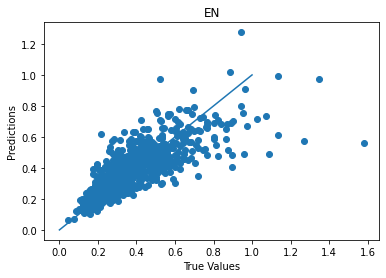

In [ ]:
plt.scatter(y_test, y_pred_EN)
x_vals = [0, 1]
y_vals = [0, 1]
plt.plot(x_vals, y_vals)
plt.title('EN')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [ ]:
n_trees = np.array([50, 100, 150, 200])
d_trees = np.array([5, 10, 20, 30])
MSE_scores_RF = pd.DataFrame(np.zeros((4,4)))
MSE_scores_RF.columns = d_trees
MSE_scores_RF.index = n_trees

In [ ]:
for n_tree in n_trees:
    for d_tree in d_trees:
        model = RandomForestRegressor(n_estimators = n_tree, max_depth = d_tree)
        cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
        scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
        MSE_scores_RF[d_tree][n_tree] = -round(np.mean(scores),5)
        print(n_tree, " ", d_tree)
print('job done')

50   5
50   10
50   20
50   30
100   5
100   10
100   20
100   30
150   5
150   10
150   20
150   30
200   5
200   10
200   20
200   30
job done


In [ ]:
MSE_scores_RF

,5,10,20,30
50,0.01861,0.01900,0.01901,0.01911
100,0.01861,0.01907,0.01892,0.01900
150,0.01870,0.01893,0.01873,0.01895
200,0.01857,0.01865,0.01903,0.01886


In [ ]:
opt_model_RF = RandomForestRegressor(n_estimators = 200, max_depth = 5)
opt_model_RF.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=200)

In [ ]:
y_pred_RF = opt_model_RF.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_pred_RF)

0.015538203979805374

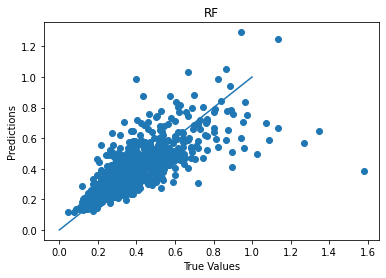

In [ ]:
plt.scatter(y_test, y_pred_RF)
x_vals = [0, 1]
y_vals = [0, 1]
plt.plot(x_vals, y_vals)
plt.title('RF')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [ ]:
from xgboost import XGBRegressor

In [ ]:
learning_rates = [0.01, 0.1, 1]
n_boosting_stages = np.array([50, 100, 200, 300])
MSE_scores_GB = pd.DataFrame(np.zeros((4,3)))
MSE_scores_GB.columns = learning_rates
MSE_scores_GB.index = n_boosting_stages

In [ ]:
for lr in learning_rates:
    for nbs in n_boosting_stages:
        model = XGBRegressor(n_estimators = nbs, learning_rate = lr)
        cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
        scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
        MSE_scores_GB[lr][nbs] = -round(np.mean(scores),5)
        print(lr, " ", nbs)
print('job done')

0.01   50
0.01   100
0.01   200
0.01   300
0.1   50
0.1   100
0.1   200
0.1   300
1   50
1   100
1   200
1   300
job done


In [ ]:
MSE_scores_GB

,0.01,0.10,1.00
50,0.03395,0.01843,0.02758
100,0.02521,0.01855,0.02980
200,0.01985,0.01899,0.03113
300,0.01877,0.01949,0.03158


In [ ]:
opt_model_GB = XGBRegressor(n_estimators = 50, learning_rate = 0.1, objective="reg:squarederror")
opt_model_GB.fit(X_train, y_train)

XGBRegressor(n_estimators=50, objective='reg:squarederror')

In [ ]:
y_pred_GB = opt_model_GB.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_pred_GB)

0.01467833712845744

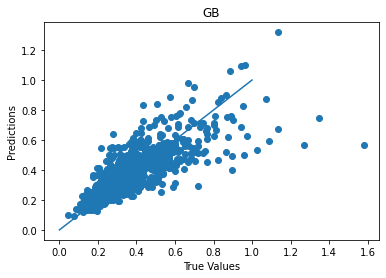

In [ ]:
plt.scatter(y_test, y_pred_GB)
x_vals = [0, 1]
y_vals = [0, 1]
plt.plot(x_vals, y_vals)
plt.title('GB')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [ ]:
poly = PolynomialFeatures(2)

In [ ]:
X_train.columns

Index(['Month', 'Temp', 'Raw_TP', 'PE_Flow', 'PE_SP', 'PE_fTP', 'SLBk',
       't1_TP'],
      dtype='object')

In [ ]:
#X_train_poly = poly.fit_transform(X_train[['PE_TP','Temp', 'Raw_TP', 'PE_flow', 'PE_BOD', 'SFE_TSS', 'SLBk']])
X_train_poly = poly.fit_transform(X_train)

In [ ]:
X_train_poly.shape

(2373, 45)

In [ ]:
Poly_RModel = LinearRegression()

In [ ]:
Poly_RModel.fit(X_train_poly, y_train)

LinearRegression()

In [ ]:
#X_test_poly = poly.fit_transform(X_test[['PE_TP','Temp', 'Raw_TP', 'PE_flow', 'PE_BOD', 'SFE_TSS', 'SLBk']])
#X_test_poly=np.concatenate((X_test_poly, X_test[['Winter', 'Fall', 'Summer', 'Spring', 'Mn', 'Ts', 'Wed', 'Th','Sat', 'Sun']].values), axis = 1)
X_test_poly = poly.fit_transform(X_test)

y_pred_polyReg = Poly_RModel.predict(X_test_poly)

In [ ]:
mean_squared_error(y_test,y_pred_polyReg)

0.014691359858304368

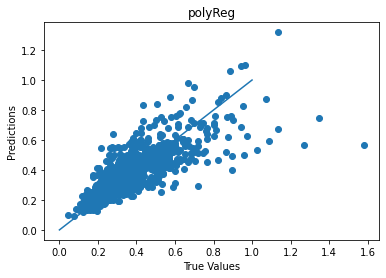

In [ ]:
plt.scatter(y_test, y_pred_GB)
x_vals = [0, 1]
y_vals = [0, 1]
plt.plot(x_vals, y_vals)
plt.title('polyReg')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [ ]:
y_pred_NN1.shape

(791, 1)

In [ ]:
y_pred_RF.shape

(791,)

In [ ]:
y_pred_merge = (y_pred_GB+y_pred_RF)/2

In [ ]:
mean_squared_error(y_test,y_pred_merge)

0.014810871806279715

In [ ]:
#print("0.74 Lasso Regression") # Lasso at the start
print(round(m.score(X_test, y_test),3), "Linear SVR")
print(round(m_SVR.score(X_test, y_test),3), "RBF SVR")
print(round(LRModel.score(X_test, y_test),3), "Linear Regression")
print(round(opt_model_EN.score(X_test,y_test),3), "Elastic Net")
print(round(opt_model_GB.score(X_test, y_test),3),"XG Boosting")
print(round(opt_model_RF.score(X_test, y_test),3), "Random Forest Regressor")
print(round(Poly_RModel.score(X_test_poly, y_test),3),"Polynomial Regression")
print(round(r2_score(y_test, y_pred_NN1),3),"Vanilla Neural Network")
print(round(r2_score(y_test_LSTM, y_pred_lstm),3),"LSTM network")

0.6 Linear SVR
0.535 RBF SVR
0.594 Linear Regression
0.597 Elastic Net
0.594 XG Boosting
0.569 Random Forest Regressor
0.593 Polynomial Regression
0.58 Vanilla Neural Network
0.595 LSTM network


In [ ]:
svr_preds = m_SVR.predict(X)